<a href="https://colab.research.google.com/github/Polinysha/all-project/blob/main/CUPED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMPREHENSIVE CUPED EXPERIMENT

1. Проверка корреляции в данных...
Корреляция между пре- и пост-тестом: 0.742

2. Тестирование ошибок первого рода...
Testing Type I error (A/A tests)...
Progress: 0/1000
Progress: 200/1000
Progress: 400/1000
Progress: 600/1000
Progress: 800/1000
Type I errors: {'classic': np.float64(0.047), 'cuped_control': np.float64(0.045), 'cuped_treatment': np.float64(0.046), 'multi_cuped': np.float64(0.048)}

3. Тестирование статистической мощности...
Testing effect size: 0.05
  Progress: 0/500
  Progress: 100/500
  Progress: 200/500
  Progress: 300/500
  Progress: 400/500
Testing effect size: 0.1
  Progress: 0/500
  Progress: 100/500
  Progress: 200/500
  Progress: 300/500
  Progress: 400/500
Testing effect size: 0.15
  Progress: 0/500
  Progress: 100/500
  Progress: 200/500
  Progress: 300/500
  Progress: 400/500
Testing effect size: 0.2
  Progress: 0/500
  Progress: 100/500
  Progress: 200/500
  Progress: 300/500
  Progress: 400/500
Testing effect size: 0.25
  P

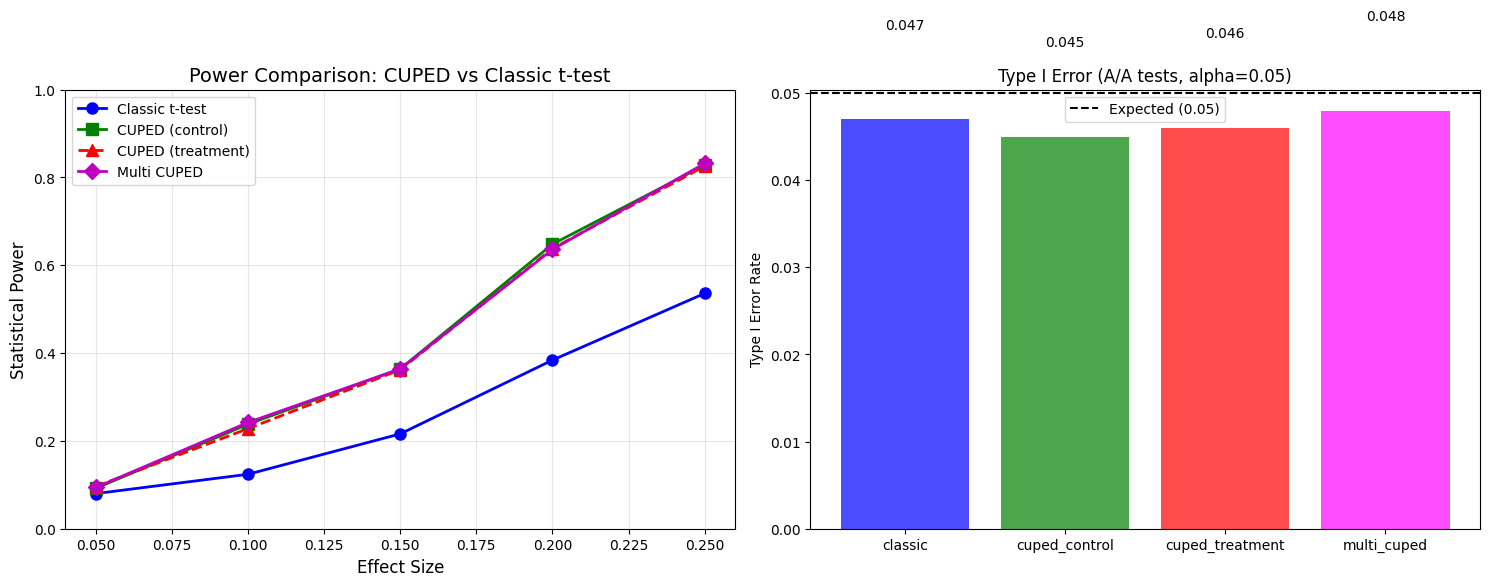


Power Comparison Table
Effect Size  Classic    CUPED(C)   CUPED(T)   Multi-CUPED 
----------------------------------------------------------------------
0.05         0.080      0.092      0.096      0.094       
0.1          0.124      0.238      0.228      0.242       
0.15         0.216      0.364      0.362      0.364       
0.2          0.384      0.648      0.638      0.636       
0.25         0.536      0.828      0.826      0.832       

5. Анализ смещения при оценке на тестовой группе...

Демонстрация смещения при оценке на тестовой группе
Progress: 0/1000
Progress: 200/1000
Progress: 400/1000
Progress: 600/1000
Progress: 800/1000

Результаты:
Среднее смещение theta: -0.0023 ± 0.0429
Type I error (оценка на контроле): 0.0480
Type I error (оценка на тесте): 0.0480
Относительное смещение Type I error: 4.0%


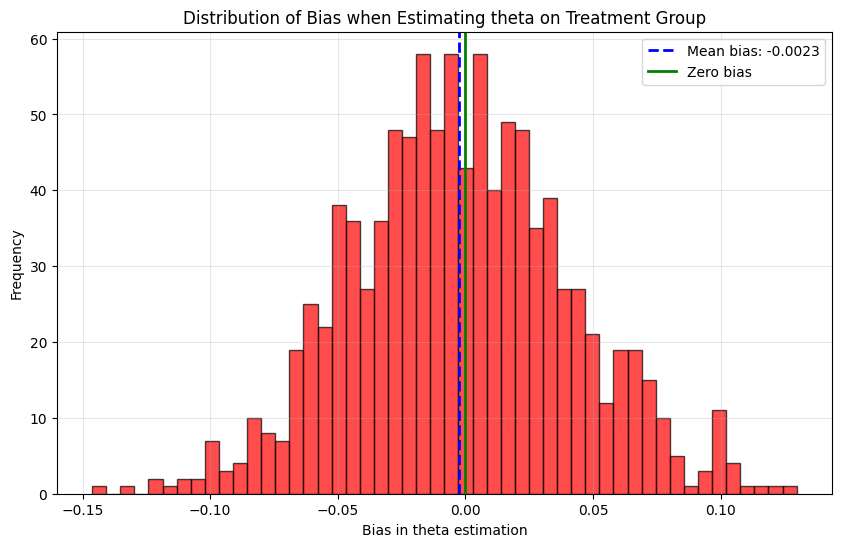


6. Анализ влияния уровня корреляции...

Анализ влияния корреляции на эффективность CUPED
Анализ для корреляции: 0.1
  Progress: 0/300
  Progress: 100/300
  Progress: 200/300
Анализ для корреляции: 0.3
  Progress: 0/300
  Progress: 100/300
  Progress: 200/300
Анализ для корреляции: 0.5
  Progress: 0/300
  Progress: 100/300
  Progress: 200/300
Анализ для корреляции: 0.7
  Progress: 0/300
  Progress: 100/300
  Progress: 200/300
Анализ для корреляции: 0.9
  Progress: 0/300
  Progress: 100/300
  Progress: 200/300


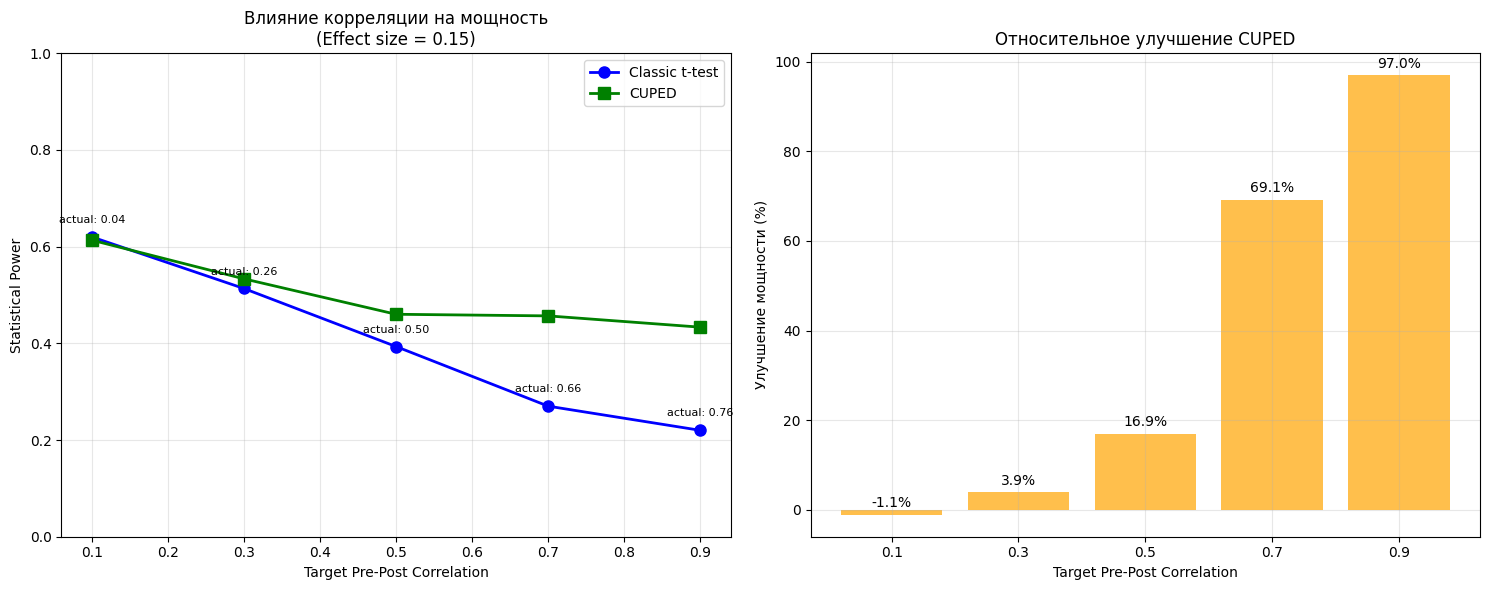


Correlation Impact Results:
Target Corr  Actual Corr  Classic    CUPED      Improvement 
------------------------------------------------------------
0.1          0.038        0.620      0.613      -1.1        %
0.3          0.265        0.513      0.533      3.9         %
0.5          0.500        0.393      0.460      16.9        %
0.7          0.661        0.270      0.457      69.1        %
0.9          0.763        0.220      0.433      97.0        %

ЭКСПЕРИМЕНТ ЗАВЕРШЕН


In [ ]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

def generate_data_improved(n=1000, effect_size=0.0, pre_correlation=0.7, noise_std=1.0):
    """Улучшенная генерация данных с сильной корреляцией пре-пост тестов"""

    user_characteristics = np.random.normal(0, 2, size=n)

    pre_test = user_characteristics * pre_correlation + np.random.normal(0, noise_std, size=n)

    treatment = np.random.binomial(1, 0.5, size=n)

    post_test = (user_characteristics * pre_correlation +
                 treatment * effect_size +
                 np.random.normal(0, noise_std, size=n))

    return pre_test, post_test, treatment

def classic_ttest(pre_test, post_test, treatment):
    """Классический t-test на пост-тестовых метриках"""
    control_post = post_test[treatment == 0]
    treatment_post = post_test[treatment == 1]
    return scipy.stats.ttest_ind(treatment_post, control_post, equal_var=False).pvalue

def cuped_method(pre_test, post_test, treatment, use_control_group=True):
    """Метод CUPED"""
    if use_control_group:
        control_mask = (treatment == 0)
        if np.sum(control_mask) > 10 and np.var(pre_test[control_mask]) > 1e-10:
            theta = np.cov(pre_test[control_mask], post_test[control_mask])[0, 1] / np.var(pre_test[control_mask])
        else:
            theta = 0
    else:
        treatment_mask = (treatment == 1)
        if np.sum(treatment_mask) > 10 and np.var(pre_test[treatment_mask]) > 1e-10:
            theta = np.cov(pre_test[treatment_mask], post_test[treatment_mask])[0, 1] / np.var(pre_test[treatment_mask])
        else:
            theta = 0

    adjusted_post = post_test - theta * (pre_test - np.mean(pre_test))

    control_adj = adjusted_post[treatment == 0]
    treatment_adj = adjusted_post[treatment == 1]

    return scipy.stats.ttest_ind(treatment_adj, control_adj, equal_var=False).pvalue

def multi_cuped_method(pre_test, other_covariates, post_test, treatment):
    """CUPED с несколькими предикторами"""
    X = np.column_stack([pre_test] + other_covariates)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    control_mask = (treatment == 0)

    if len(X_scaled[control_mask]) > X_scaled.shape[1] + 1:
        model = LinearRegression()
        model.fit(X_scaled[control_mask], post_test[control_mask])

        predictions = model.predict(X_scaled)

        adjusted_post = post_test - predictions + np.mean(post_test[control_mask])
    else:
        adjusted_post = post_test

    control_adj = adjusted_post[treatment == 0]
    treatment_adj = adjusted_post[treatment == 1]

    return scipy.stats.ttest_ind(treatment_adj, control_adj, equal_var=False).pvalue

def test_type1_error(n_simulations=1000, n_samples=1000, pre_correlation=0.8):
    """Тестирование ошибки первого рода"""
    print("Testing Type I error (A/A tests)...")

    results = {
        'classic': [],
        'cuped_control': [],
        'cuped_treatment': [],
        'multi_cuped': []
    }

    for i in range(n_simulations):
        if i % 200 == 0:
            print(f"Progress: {i}/{n_simulations}")

        pre_test, post_test, treatment = generate_data_improved(
            n_samples, effect_size=0.0, pre_correlation=pre_correlation
        )

        other_covariates = [
            np.random.normal(0, 1, size=len(pre_test)) + pre_test * 0.5,
            np.random.normal(0, 1, size=len(pre_test)) + pre_test * 0.3
        ]

        results['classic'].append(classic_ttest(pre_test, post_test, treatment))
        results['cuped_control'].append(cuped_method(pre_test, post_test, treatment, use_control_group=True))
        results['cuped_treatment'].append(cuped_method(pre_test, post_test, treatment, use_control_group=False))
        results['multi_cuped'].append(multi_cuped_method(pre_test, other_covariates, post_test, treatment))

    alpha = 0.05
    type1_errors = {}
    for method, pvalues in results.items():
        type1_errors[method] = np.mean(np.array(pvalues) < alpha)

    return type1_errors, results

def test_power_comprehensive(n_simulations=500, n_samples=1000, pre_correlation=0.8):
    """Комплексное тестирование мощности для разных размеров эффекта"""
    effect_sizes = [0.05, 0.1, 0.15, 0.2, 0.25]
    results = {effect: {} for effect in effect_sizes}

    for effect_size in effect_sizes:
        print(f"Testing effect size: {effect_size}")

        classic_power = []
        cuped_control_power = []
        cuped_treatment_power = []
        multi_cuped_power = []

        for i in range(n_simulations):
            if i % 100 == 0:
                print(f"  Progress: {i}/{n_simulations}")

            pre_test, post_test, treatment = generate_data_improved(
                n_samples, effect_size=effect_size, pre_correlation=pre_correlation
            )
            other_covariates = [
                np.random.normal(0, 1, size=len(pre_test)) + pre_test * 0.5,
                np.random.normal(0, 1, size=len(pre_test)) + pre_test * 0.3
            ]

            classic_power.append(classic_ttest(pre_test, post_test, treatment) < 0.05)
            cuped_control_power.append(cuped_method(pre_test, post_test, treatment, True) < 0.05)
            cuped_treatment_power.append(cuped_method(pre_test, post_test, treatment, False) < 0.05)
            multi_cuped_power.append(multi_cuped_method(pre_test, other_covariates, post_test, treatment) < 0.05)

        results[effect_size] = {
            'classic': np.mean(classic_power),
            'cuped_control': np.mean(cuped_control_power),
            'cuped_treatment': np.mean(cuped_treatment_power),
            'multi_cuped': np.mean(multi_cuped_power)
        }

    return results

def plot_comprehensive_results(power_results, type1_errors=None):
    """Визуализация комплексных результатов"""
    effect_sizes = list(power_results.keys())

    classic_power = [power_results[eff]['classic'] for eff in effect_sizes]
    cuped_control_power = [power_results[eff]['cuped_control'] for eff in effect_sizes]
    cuped_treatment_power = [power_results[eff]['cuped_treatment'] for eff in effect_sizes]
    multi_cuped_power = [power_results[eff]['multi_cuped'] for eff in effect_sizes]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    ax1.plot(effect_sizes, classic_power, 'b-o', label='Classic t-test', linewidth=2, markersize=8)
    ax1.plot(effect_sizes, cuped_control_power, 'g-s', label='CUPED (control)', linewidth=2, markersize=8)
    ax1.plot(effect_sizes, cuped_treatment_power, 'r--^', label='CUPED (treatment)', linewidth=2, markersize=8)
    ax1.plot(effect_sizes, multi_cuped_power, 'm-D', label='Multi CUPED', linewidth=2, markersize=8)

    ax1.set_xlabel('Effect Size', fontsize=12)
    ax1.set_ylabel('Statistical Power', fontsize=12)
    ax1.set_title('Power Comparison: CUPED vs Classic t-test', fontsize=14)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)

    if type1_errors is not None:
        methods = list(type1_errors.keys())
        errors = [type1_errors[m] for m in methods]
        colors = ['blue', 'green', 'red', 'magenta']

        bars = ax2.bar(methods, errors, color=colors, alpha=0.7)
        ax2.axhline(y=0.05, color='black', linestyle='--', label='Expected (0.05)')
        ax2.set_ylabel('Type I Error Rate')
        ax2.set_title('Type I Error (A/A tests, alpha=0.05)')
        ax2.legend()

        for bar, error in zip(bars, errors):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{error:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    print("\n" + "="*70)
    print("Power Comparison Table")
    print("="*70)
    print(f"{'Effect Size':<12} {'Classic':<10} {'CUPED(C)':<10} {'CUPED(T)':<10} {'Multi-CUPED':<12}")
    print("-"*70)
    for effect_size in effect_sizes:
        classic = power_results[effect_size]['classic']
        cuped_c = power_results[effect_size]['cuped_control']
        cuped_t = power_results[effect_size]['cuped_treatment']
        multi = power_results[effect_size]['multi_cuped']
        print(f"{effect_size:<12} {classic:<10.3f} {cuped_c:<10.3f} {cuped_t:<10.3f} {multi:<12.3f}")

def demonstrate_treatment_bias(n_simulations=1000):
    """Демонстрация смещения при оценке на тестовой группе"""
    print("\n" + "="*60)
    print("Демонстрация смещения при оценке на тестовой группе")
    print("="*60)

    theta_biases = []
    type1_errors_control = []
    type1_errors_treatment = []

    for i in range(n_simulations):
        if i % 200 == 0:
            print(f"Progress: {i}/{n_simulations}")

        pre_test, post_test, treatment = generate_data_improved(n=1000, effect_size=0.0, pre_correlation=0.8)

        control_mask = (treatment == 0)
        treatment_mask = (treatment == 1)

        if (np.sum(control_mask) > 10 and np.var(pre_test[control_mask]) > 1e-10 and
            np.sum(treatment_mask) > 10 and np.var(pre_test[treatment_mask]) > 1e-10):

            theta_control = np.cov(pre_test[control_mask], post_test[control_mask])[0, 1] / np.var(pre_test[control_mask])
            theta_treatment = np.cov(pre_test[treatment_mask], post_test[treatment_mask])[0, 1] / np.var(pre_test[treatment_mask])

            bias = theta_treatment - theta_control
            theta_biases.append(bias)

            pval_control = cuped_method(pre_test, post_test, treatment, use_control_group=True)
            pval_treatment = cuped_method(pre_test, post_test, treatment, use_control_group=False)

            type1_errors_control.append(pval_control < 0.05)
            type1_errors_treatment.append(pval_treatment < 0.05)

    mean_bias = np.mean(theta_biases)
    std_bias = np.std(theta_biases)
    type1_control = np.mean(type1_errors_control)
    type1_treatment = np.mean(type1_errors_treatment)

    print(f"\nРезультаты:")
    print(f"Среднее смещение theta: {mean_bias:.4f} ± {std_bias:.4f}")
    print(f"Type I error (оценка на контроле): {type1_control:.4f}")
    print(f"Type I error (оценка на тесте): {type1_treatment:.4f}")
    print(f"Относительное смещение Type I error: {abs(type1_treatment - 0.05)/0.05*100:.1f}%")

    plt.figure(figsize=(10, 6))
    plt.hist(theta_biases, bins=50, alpha=0.7, color='red', edgecolor='black')
    plt.axvline(mean_bias, color='blue', linestyle='--', linewidth=2, label=f'Mean bias: {mean_bias:.4f}')
    plt.axvline(0, color='green', linestyle='-', linewidth=2, label='Zero bias')
    plt.xlabel('Bias in theta estimation')
    plt.ylabel('Frequency')
    plt.title('Distribution of Bias when Estimating theta on Treatment Group')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return mean_bias, type1_control, type1_treatment

def correlation_impact_analysis():
    """Анализ влияния корреляции на эффективность CUPED"""
    print("\n" + "="*60)
    print("Анализ влияния корреляции на эффективность CUPED")
    print("="*60)

    correlations = [0.1, 0.3, 0.5, 0.7, 0.9]
    effect_size = 0.15
    n_simulations = 300

    results = []

    for corr in correlations:
        print(f"Анализ для корреляции: {corr}")

        classic_power = []
        cuped_power = []
        actual_correlations = []

        for i in range(n_simulations):
            if i % 100 == 0:
                print(f"  Progress: {i}/{n_simulations}")

            pre_test, post_test, treatment = generate_data_improved(
                n=1000, effect_size=effect_size, pre_correlation=corr
            )

            actual_corr = np.corrcoef(pre_test, post_test)[0, 1]
            actual_correlations.append(actual_corr)

            classic_power.append(classic_ttest(pre_test, post_test, treatment) < 0.05)
            cuped_power.append(cuped_method(pre_test, post_test, treatment, True) < 0.05)

        mean_actual_corr = np.mean(actual_correlations)
        results.append({
            'target_correlation': corr,
            'actual_correlation': mean_actual_corr,
            'classic': np.mean(classic_power),
            'cuped': np.mean(cuped_power),
            'improvement': (np.mean(cuped_power) - np.mean(classic_power)) / np.mean(classic_power) * 100
        })

    target_corrs = [r['target_correlation'] for r in results]
    actual_corrs = [r['actual_correlation'] for r in results]
    classic = [r['classic'] for r in results]
    cuped = [r['cuped'] for r in results]
    improvements = [r['improvement'] for r in results]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    ax1.plot(target_corrs, classic, 'b-o', label='Classic t-test', linewidth=2, markersize=8)
    ax1.plot(target_corrs, cuped, 'g-s', label='CUPED', linewidth=2, markersize=8)
    ax1.set_xlabel('Target Pre-Post Correlation')
    ax1.set_ylabel('Statistical Power')
    ax1.set_title('Влияние корреляции на мощность\n(Effect size = 0.15)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)

    for i, (target, actual) in enumerate(zip(target_corrs, actual_corrs)):
        ax1.annotate(f'actual: {actual:.2f}', (target, classic[i]),
                    textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

    ax2.bar([str(c) for c in target_corrs], improvements, color='orange', alpha=0.7)
    ax2.set_xlabel('Target Pre-Post Correlation')
    ax2.set_ylabel('Улучшение мощности (%)')
    ax2.set_title('Относительное улучшение CUPED')
    ax2.grid(True, alpha=0.3)

    for i, v in enumerate(improvements):
        ax2.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    print("\nCorrelation Impact Results:")
    print(f"{'Target Corr':<12} {'Actual Corr':<12} {'Classic':<10} {'CUPED':<10} {'Improvement':<12}")
    print("-"*60)
    for r in results:
        print(f"{r['target_correlation']:<12.1f} {r['actual_correlation']:<12.3f} "
              f"{r['classic']:<10.3f} {r['cuped']:<10.3f} {r['improvement']:<12.1f}%")

    return results

def main_experiment():
    """Основной эксперимент с CUPED"""
    print("="*70)
    print("COMPREHENSIVE CUPED EXPERIMENT")
    print("="*70)

    print("\n1. Проверка корреляции в данных...")
    pre_test, post_test, treatment = generate_data_improved(n=1000, pre_correlation=0.8)
    correlation = np.corrcoef(pre_test, post_test)[0, 1]
    print(f"Корреляция между пре- и пост-тестом: {correlation:.3f}")

    print("\n2. Тестирование ошибок первого рода...")
    type1_errors, _ = test_type1_error(n_simulations=1000, pre_correlation=0.8)
    print("Type I errors:", type1_errors)

    print("\n3. Тестирование статистической мощности...")
    power_results = test_power_comprehensive(n_simulations=500, pre_correlation=0.8)

    print("\n4. Визуализация результатов...")
    plot_comprehensive_results(power_results, type1_errors)

    print("\n5. Анализ смещения при оценке на тестовой группе...")
    bias_results = demonstrate_treatment_bias(n_simulations=1000)

    print("\n6. Анализ влияния уровня корреляции...")
    correlation_results = correlation_impact_analysis()

    print("\n" + "="*70)
    print("ЭКСПЕРИМЕНТ ЗАВЕРШЕН")
    print("="*70)

if __name__ == "__main__":
    main_experiment()